# Aassignment 3 Part A : Decision Tree & Random Forest

In [1]:
from xclib.data import data_utils
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

import itertools
from tqdm import tqdm
from time import time

from joblib import Parallel, delayed
import multiprocessing as mp
import matplotlib.pyplot as plt
import math

In [2]:
X_train = data_utils.read_sparse_file('./data/train_x.txt', n_features=482).toarray()
X_test = data_utils.read_sparse_file('./data/test_x.txt', n_features=482).toarray()
X_val = data_utils.read_sparse_file('./data/valid_x.txt', n_features=482).toarray()

Y_train = np.array(open('./data/train_y.txt','r').read().strip().split('\n'), dtype=int)
Y_test = np.array(open('./data/test_y.txt','r').read().strip().split('\n'), dtype=int)
Y_val = np.array(open('./data/valid_y.txt','r').read().strip().split('\n'), dtype=int)

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)
print(X_val.shape, Y_val.shape)

(64713, 482) (64713,)
(21571, 482) (21571,)
(21572, 482) (21572,)


In [3]:
print(np.unique(Y_train, return_counts=True))
print(np.unique(Y_test, return_counts=True))
print(np.unique(Y_val, return_counts=True))

#Almost balanced dataset

(array([0, 1]), array([30560, 34153]))
(array([0, 1]), array([10151, 11420]))
(array([0, 1]), array([10302, 11270]))


In [4]:
ind_lst = []
for i in range(X_train.shape[1]):
    if (X_train[:,i].min() == 0) and (X_train[:,i].max() == 0):
        ind_lst.append(i)

print('%d columns were having only zero values.'%(len(ind_lst)))

#Removing columns with zero values
X_train = np.delete(X_train, ind_lst, axis=1)
X_test = np.delete(X_test, ind_lst, axis=1)
X_val = np.delete(X_val, ind_lst, axis=1)

#shape of datasets after Removing columns with zero values
print('Shape of X_train',X_train.shape)
print('Shape of X_test',X_test.shape)
print('Shape of X_val',X_val.shape)

219 columns were having only zero values.
Shape of X_train (64713, 263)
Shape of X_test (21571, 263)
Shape of X_val (21572, 263)


## Question (a): Implementing Decision Tree From scratch :

In [5]:
class DTNode:
    '''
        Class representing node of 
    '''
    def __init__(self, splitFeat=None, splitVal=None, majorityClass=None, parent=None, isLeft=True, X=None, Y=None, isLeaf=False):
        self.splitFeat = splitFeat
        self.splitVal = splitVal
        self.majorityClass = majorityClass
        self.isLeaf = False
        self.left = None
        self.right = None
        self.X, self.Y = X, Y
        self.nodes_subtree = None
        
    def is_leaf(self):
        return self.splitFeat is None or self.isLeaf 
        
    def __str__(self):
        return 'SplitFeat : '+str(self.splitFeat)+'\nSplitVal : '+str(self.splitVal)+'\nMajorityClass : '+str(self.majorityClass)+'\n'
    
    def __repr__(self):
        return 'SplitFeat : '+str(self.splitFeat)+'\nSplitVal : '+str(self.splitVal)+'\nMajorityClass : '+str(self.majorityClass)+'\n'

In [6]:
class DecisionTreeClassifier:
    '''
        Implementation of decision tree classifier
        
        Parameters:
        *******************
            
        get_train_data(Default:False) : [boolean]
            If true then train, test and Validation accuracy recorded
            after adding record_data_frequency number of nodes

        record_data_frequency(Default:100) : [int]
            After how many nodes to record accuracy data
                
        Attributes:
        *******************
        
        cnt : [int]
            numer of node in tree
        root : [DTNode]
            Root of the decision Tree
        train_data : [Dictionary]
            Dictionary containing accuracies over Train, Test and Validation Datasets
            recorded as tree grows (You need to set get_train_data=True to get this)
                
        Methods: 
        *******************
        fit(self, X, Y[, X_test, Y_test, X_val, Y_val]) : [None]
            This method builds decision tree iteratively using 
            X and Y as training Dataset [and records accuracies].
            (If you have set get_train_data=True then pass X_test, Y_test and X_val, Y_val)

        predict(self, X) : [list]
            Returns list of predicted class labels for datapoints in X

        score(self, X, Y_true) : [float]
            Returns accuracy over dataset X and ground truth Y_true

        plot_training_data(self) : [None]
            Plots number of nodes v/s accuracies if get_train_data=True
    '''
    def __init__(self, get_train_data=False, record_data_frequency=100):
        self.root = None
        self.cnt = 0
        self.leafNodes = 0
        self.get_train_data = get_train_data
        self.record_data_frequency = record_data_frequency
        if self.get_train_data:
            self.train_data = {'train_acc':[], 'test_acc':[], 'val_acc':[]}
    
    def __str__(self):
        return 'DecisionTreeClassifier\n\nParameters : \n\tget_train_data='+str(self.get_train_data)+'\n\trecord_data_frequency='+str(self.record_data_frequency)+\
                '\n\nAttributes : \n\tTotal Number of nodes='+str(self.cnt)+'\n\tNumber of leafe nodes='+str(self.leafNodes)
    
    def __repr__(self):
        return 'DecisionTreeClassifier\n\nParameters : \n\tget_train_data='+str(self.get_train_data)+'\n\trecord_data_frequency='+str(self.record_data_frequency)+\
                '\n\nAttributes : \n\tTotal Number of nodes='+str(self.cnt)+'\n\tNumber of leafe nodes='+str(self.leafNodes)
        
    def fit(self, X, Y, X_test=None, Y_test=None, X_val=None, Y_val=None):
        '''
            Builds Tree using viven Train Dataset
        '''
        if self.get_train_data and (X_test is None or Y_test is None or X_val is None or Y_val is None):
            raise Exception('Please pass test and validation data to get train_data or pass get_train_data=False')
        
        queue = []
        X_train = X.copy()
        Y_train = Y.copy()
        self.root = DTNode(X=X, Y=Y)
        queue.append(self.root)
        
        while queue!=[]:
            self.cnt+=1

            node = queue.pop(0)
            X_, Y_ = node.X, node.Y
            n_samples_, n_feat_ = X_.shape
            nY1_ = (Y_==1).sum()
            nY0_ = n_samples_ - nY1_
            majClass = 1 if nY1_>nY0_ else 0
            node.majorityClass=majClass
            if (nY1_ == 0) or (nY0_==0):
                self.leafNodes+=1
                node.isLeaf=True
                if self.get_train_data and (self.cnt-1)%self.record_data_frequency==0:
                    self._record_accuracies(X_train, Y_train, X_test, Y_test, X_val, Y_val)
                continue
            else:
                bestSplit_, median_, maxIG_ = self._getBestSplit(X_, Y_)
                if(bestSplit_==-np.inf):# or maxIG_==0:
                    self.leafNodes+=1
                    node.isLeaf=True
                    if self.get_train_data and (self.cnt-1)%self.record_data_frequency==0:
                        self._record_accuracies(X_train, Y_train, X_test, Y_test, X_val, Y_val)
                    continue
                node.splitFeat = bestSplit_
                node.splitVal = median_
                node.left = DTNode(majorityClass=majClass,\
                                   X=X_[X_[:,bestSplit_]<=median_], Y=Y_[X_[:,bestSplit_]<=median_])
                node.right = DTNode(majorityClass=majClass,\
                                   X=X_[X_[:,bestSplit_]>median_], Y=Y_[X_[:,bestSplit_]>median_])
                queue.append(node.left)
                queue.append(node.right)
                node.X=None
                node.Y=None
            if self.get_train_data and (self.cnt-1)%self.record_data_frequency==0:
                self._record_accuracies(X_train, Y_train, X_test, Y_test, X_val, Y_val)
        if self.get_train_data:
                self._record_accuracies(X_train, Y_train, X_test, Y_test, X_val, Y_val)
            
    
        
    def _record_accuracies(self, X_train, Y_train, X_test, Y_test, X_val, Y_val):
        '''
            Records train, test and validation accuracy in train_data dictionary at given state of the tree
        '''
        self.train_data['train_acc'].append(self.score(X_train, Y_train))
        self.train_data['test_acc'].append(self.score(X_test, Y_test))
        self.train_data['val_acc'].append(self.score(X_val, Y_val))
        
    def _getBestSplit(self, X, Y):  
        '''
            Returns (optimal_split, optimal_median, max_IG)
                optimal_split : feature index of dataset X splitting which maximizes Info. gain
                optimal_median : median of optimal_split feature
                max_IG : maximum Information gain across all features
        '''
        n_samples, n_feat = X.shape
        optimal_split, optimal_median = -np.inf, -np.inf
        max_IG = -np.inf
        median_arr = np.median(X, axis=0)
        for i in range(n_feat):
            median = median_arr[i]
            ig = self._getInformationGain(X,Y,i,median)
            if ig > max_IG:
                max_IG = ig
                optimal_split = i
                optimal_median = median
        return (optimal_split, optimal_median, max_IG)
        
    def _entropy(self, X, Y):
        '''
            This method computes entropy of given node
        '''
        n_samples, n_feat = X.shape
        nY1 = (Y==1).sum()
        nY0 = n_samples-nY1
        
        if n_samples==0:
            return np.inf
        elif nY1==0 or nY0==0:
            return 0
        else:
            return (-nY0*math.log(nY0/n_samples)-nY1*math.log(nY1/n_samples))/n_samples
    
    def _getInformationGain(self, X, Y, i, median):
        '''
            return information gain if we split with ith Feature
        '''
        entBefore = self._entropy(X,Y)
        
        X_lte = X[X[:,i]<=median]
        Y_lte = Y[X[:,i]<=median]
        X_gt = X[X[:,i]>median]
        Y_gt = Y[X[:,i]>median]
        
        entAfter = ((Y_lte.shape[0])*self._entropy(X_lte, Y_lte) + (Y_gt.shape[0])*self._entropy(X_gt, Y_gt))/(Y.shape[0])
        return (entBefore-entAfter)
    
    def score(self, X, Y_true):
        '''
            Return accuracy score over dataset X and actual label Y
        '''
        return (self.predict(X)==Y_true).sum()/Y_true.shape[0]
    
    def predict(self, X):
        '''
            Returns prediction for given Dataset X
        '''
        pred=[]
        for row in X:
            pred.append(self._predict(row))
        return pred
    
    def _predict(self, row):
        '''
            Returns predicted class label for one datapoint row
        '''
        node=self.root
        while(not node.is_leaf()):#node.left is not None and not node.isDeleted):
            if row[node.splitFeat]<=node.splitVal:# and node.left is not None:
                node=node.left
            elif row[node.splitFeat]>node.splitVal:# and node.right is not None:
                node=node.right
        pred = node.majorityClass
        return pred
    
    def plot_training_data(self):
        '''
            Plots train, test and validation accuracy as number of nodes increases during training
        '''
        if self.get_train_data:
            plt.figure(figsize=(12,8))
            n_nodes_lst = list(range(1,(len(self.train_data['train_acc'])-1)*self.record_data_frequency, self.record_data_frequency))
            n_nodes_lst.append(self.cnt)
            plt.plot(n_nodes_lst, self.train_data['train_acc'], label='Train Accuracy')
            plt.plot(n_nodes_lst, self.train_data['test_acc'], label='Test Accuracy')
            plt.plot(n_nodes_lst, self.train_data['val_acc'], label='Validation Accuracy')
            plt.legend()
            plt.xlabel('Number of nodes')
            plt.ylabel('Accuracies')
            plt.title('Number of nodes v/s Accuracies')
            plt.show()
        else:
            raise Exception('Please pass get_train_data=True to get this plot')

In [7]:
dt=DecisionTreeClassifier(get_train_data=False)

t0=time()
dt.fit(X_train, Y_train, X_test, Y_test, X_val, Y_val)
print('Generated tree in %.2f minutes'%((time()-t0)/60))

train_acc = dt.score(X_train, Y_train)
val_acc = dt.score(X_val, Y_val)
test_acc = dt.score(X_test, Y_test)

print('Train Accuracy :',train_acc*100)
print('Test Accuracy :',test_acc*100)
print('Validation Accuracy :',val_acc*100)
print('\n\n'+str(dt))

Generated tree in 3.01 minutes
Train Accuracy : 90.808647412421
Test Accuracy : 77.96578739974966
Validation Accuracy : 77.46615983682551


DecisionTreeClassifier

Parameters : 
	get_train_data=False
	record_data_frequency=100

Attributes : 
	Total Number of nodes=21007
	Number of leafe nodes=10504


Generated tree in 5.22 minutes
Train Accuracy : 90.808647412421
Test Accuracy : 77.96578739974966
Validation Accuracy : 77.46615983682551


DecisionTreeClassifier

Parameters : 
	get_train_data=True
	record_data_frequency=100

Attributes : 
	Total Number of nodes=21007
	Number of leafe nodes=10504


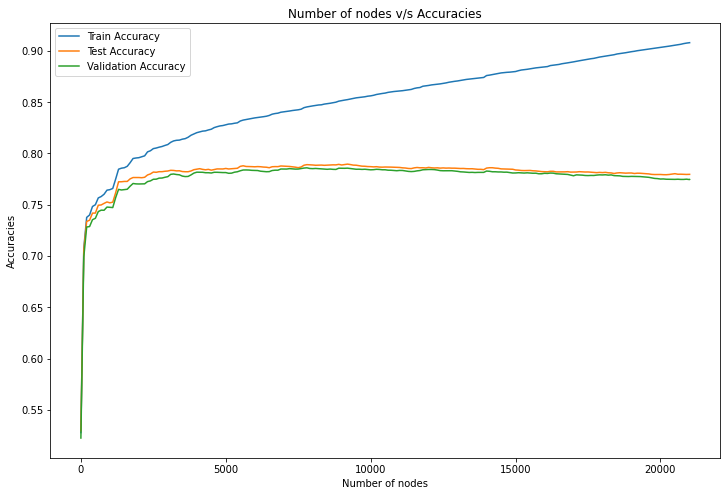

In [45]:
dt_withData=DecisionTreeClassifier(get_train_data=True)

t0=time()
dt_withData.fit(X_train, Y_train, X_test, Y_test, X_val, Y_val)
print('Generated tree in %.2f minutes'%((time()-t0)/60))

train_acc = dt_withData.score(X_train, Y_train)
val_acc = dt_withData.score(X_val, Y_val)
test_acc = dt_withData.score(X_test, Y_test)

print('Train Accuracy :',train_acc*100)
print('Test Accuracy :',test_acc*100)
print('Validation Accuracy :',val_acc*100)

print('\n\n'+str(dt_withData))
dt_withData.plot_training_data()

# Part B : Post prunning the tree

In [7]:
# import pickle
# with open('./pickles/dt.pkl', 'wb+') as f:
#     pickle.dump(dt,f)

In [7]:
import pickle
with open('pickles/dt.pkl', 'rb') as f:
    dt = pickle.load(f)

In [8]:
def set_subtree_nodes(node):
    if node.is_leaf():
        node.nodes_subtree = 1
    else:
        node.nodes_subtree = 1+set_subtree_nodes(node.left) + set_subtree_nodes(node.right)
    return node.nodes_subtree    

set_subtree_nodes(dt.root)
print(dt.root.nodes_subtree, dt.root.left.nodes_subtree+dt.root.right.nodes_subtree)

21007 21006


In [9]:
def set_indices(node, X, indices, ):
    if node.is_leaf():
        node.val_indices = indices
    else:
        lt_indices = np.logical_and((X[:,node.splitFeat]<=node.splitVal), indices)
        rt_indices = np.logical_and((X[:,node.splitFeat]>node.splitVal), indices)
        node.val_indices = np.argwhere(indices).flatten()
        set_indices(node.left, X, lt_indices)
        set_indices(node.right, X, rt_indices)
set_indices(dt.root, X_val, list(range(X_val.shape[0])))

In [10]:
def predict_val(root):
    pred = np.ones(len(Y_val), dtype=np.bool)
    queue = []
    queue.append(root)
    while queue!=[]:
        node=queue.pop(0)
        if node.is_leaf():
            pred[node.val_indices] = node.majorityClass
        else:
            queue.append(node.left)
            queue.append(node.right)
    return pred

def val_score(root):
    return sum(predict_val(root)==Y_val)*100/Y_val.shape[0]

def reset_leaves(node):
    if node.splitFeat is None:
        node.isLeaf = True
    else:
        node.isLeaf = False
        reset_leaves(node.left)
        reset_leaves(node.right)   

In [11]:
lst=[]
def post_order_lst(node):
    global lst
    if node:
        post_order_lst(node.left)
        post_order_lst(node.right)
        lst.append(node)
post_order_lst(dt.root)
len(lst)

21007

In [12]:
best_val_acc = val_score(dt.root)
nodes = len(lst)
record_dict={'train_acc':[], 'test_acc':[], 'val_acc':[], 'nodes':[]}
for node in tqdm(lst):
    if node.is_leaf():
        continue
    else:
        node.isLeaf=True
        val_acc = val_score(dt.root)
        if val_acc >= best_val_acc:
            nodes = nodes - node.nodes_subtree + 1
#             record_dict['nodes'].append(nodes)
#             record_dict['val_acc'].append(val_acc)
#             record_dict['test_acc'].append(dt.score(X_test, Y_test))
#             record_dict['train_acc'].append(dt.score(X_train, Y_train))
            best_val_acc = val_acc
        else:
            node.isLeaf=False

100%|██████████| 21007/21007 [10:13<00:00, 34.25it/s]


In [13]:
best_val_acc

82.50046356387911

In [14]:
train_acc = dt.score(X_train, Y_train)
val_acc = dt.score(X_val, Y_val)
test_acc = dt.score(X_test, Y_test)

print('Train Accuracy :',train_acc*100)
print('Test Accuracy :',test_acc*100)
print('Validation Accuracy :',val_acc*100)

Train Accuracy : 83.24447947089456
Test Accuracy : 79.75522692503824
Validation Accuracy : 82.50509920267012


In [15]:
nodes

-56011

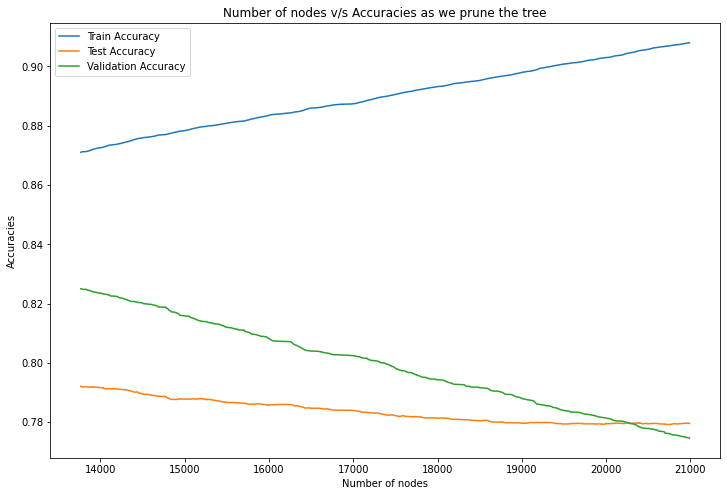

In [25]:
plt.figure(figsize=(12,8))
n_nodes_lst = record_dict['nodes']
plt.plot(n_nodes_lst, record_dict['train_acc'], label='Train Accuracy')
plt.plot(n_nodes_lst, record_dict['test_acc'], label='Test Accuracy')
plt.plot(n_nodes_lst,np.array(record_dict['val_acc'])/100, label='Validation Accuracy')
plt.legend()
plt.xlabel('Number of nodes')
plt.ylabel('Accuracies')
plt.title('Number of nodes v/s Accuracies as we prune the tree')
plt.show()

In [47]:
# def get_val_err(node, X, Y):
#     if node.is_leaf():
#         node.err = sum(dt.predict(X) !=Y)
#         node.err_diff = 0
#     else:
#         node.isLeaf = True
#         node.err = sum(dt.predict(X) !=Y)
#         node.isLeaf=False
#         lt_indices = X[:,node.splitFeat]<=node.splitVal
#         rt_indices = X[:,node.splitFeat]>node.splitVal
#         get_val_err(node.left, X[lt_indices], Y[lt_indices])
#         get_val_err(node.right, X[rt_indices], Y[rt_indices])
#         node.err_diff = node.err - node.left.err - node.right.err

# def reset_leaves(node):
#     if node.splitFeat is None:
#         node.isLeaf = True
#     else:
#         node.isLeaf = False
#         reset_leaves(node.left)
#         reset_leaves(node.right)        
        
# cnt=0
# nodes = dt.cnt
# record_dict={'train_acc':[], 'test_acc':[], 'val_acc':[]}
# def prune(node):
#     global cnt
#     global nodes
#     cnt+=1
# #     if((cnt-1)%100==0):
# #         print(nodes)
# #         record_dict['train_acc'].append(dt.score(X_train, Y_train))
# #         record_dict['val_acc'].append(dt.score(X_val, Y_val))
# #         record_dict['test_acc'].append(dt.score(X_test, Y_test))
#     if node.is_leaf() or node.err < node.left.err + node.right.err:
#         if not node.is_leaf():
# #             print(node.err, node.left.err + node.right.err)
#             nodes = nodes - node.left.nodes_subtree - node.right.nodes_subtree
#         node.isLeaf=True
#     else:
#         prune(node.left)
#         prune(node.right)


# def prune1(node):
#     global nodes
#     if node.left is not None and node.left.is_leaf():
#         if node.err < node.left.err + node.right.err:
#             nodes = nodes - node.left.nodes_subtree - node.right.nodes_subtree
#             node.isLeaf=True
#     elif node.right is not None and node.right.is_leaf():
#         if node.err < node.left.err + node.right.err:
#             nodes = nodes - node.left.nodes_subtree - node.right.nodes_subtree
#             node.isLeaf=True
#     else:
#         prune1(node.left)
#         prune1(node.right)

# nodes=dt.cnt

# def prune2(node, min_err_diff, min_err_diff_node):
#     global nodes
#     global cnt
#     cnt+=1

#     if node.is_leaf():
#         if min_err_diff < 0:
#             min_err_diff_node.isLeaf=True
#             nodes = nodes - min_err_diff_node.nodes_subtree 
#     else:
#         if node.err_diff<=min_err_diff:
#             prune2(node.left, node.err_diff, node)
#             prune2(node.right, node.err_diff, node)
#         else:
#             prune2(node.left, min_err_diff, min_err_diff_node)
#             prune2(node.right, min_err_diff, min_err_diff_node)
    

In [16]:
# def printInfo():
leaves = 0
leaves1 = 0
leaves0=0
nodes = 0
def isLeaf(node):
    return node.is_leaf()
#     if (node.left==None and node.right!=None) or (node.left!=None and node.right==None):
#         print('Problem')
#     if node.left==None and node.right==None:
#         return True
#     else:
#         return False

def dfs(node):
    global leaves
    global nodes
    global leaves1
    global leaves0

    nodes+=1
    if isLeaf(node):
        leaves += 1
        if(node.majorityClass==1):
            leaves1+=1
        else:
            leaves0+=1
        return 1

    mx_depth=0

    mx_depth = max(mx_depth, dfs(node.left))
    mx_depth = max(mx_depth, dfs(node.right))
    return mx_depth+1

print('max_depth', dfs(dt.root))
print('Number of nodes', nodes)
print('Number of leaves', leaves)
print('Number of leaves with y=1', leaves1)
print('Number of leaves with y=0', leaves0)

max_depth 49
Number of nodes 4215
Number of leaves 2108
Number of leaves with y=1 960
Number of leaves with y=0 1148


Train Accuracy : 80.61749571183533
Test Accuracy : 78.03532520513653
Validation Accuracy : 79.46412015575747


In [33]:
tree.left.err + tree.right.err

7434

In [39]:
tree.err

10302

# Part C : Getting optimal hyperparameters for Random Forest

In [5]:
grid = {'n_estimators':list(range(50, 451,100)),\
        'max_features':[x/10 for x in (range(1, 10, 2))],\
        'min_samples_split':list(range(2,11,2))
        }

In [6]:
def GridSearchUsingOOB(param_grid, n_jobs=1):
    
    params = list(itertools.product(*(param_grid[key] for key in param_grid.keys())))
    optimal_clf, optimal_oob_score = None, 0

    for (n_est, max_feat, min_sam_split) in tqdm(params):
        clf = RandomForestClassifier(n_estimators=n_est, max_features=max_feat, min_samples_split=min_sam_split, oob_score=True, n_jobs=n_jobs).fit(X_train, Y_train)
        oob_score = clf.oob_score_
        
        if oob_score>optimal_oob_score:
            optimal_clf = clf
            optimal_oob_score = oob_score    
    return optimal_clf

In [7]:
optimal_clf = GridSearchUsingOOB(grid, n_jobs=mp.cpu_count()//2)
print('\n\noptimal Classifier :\n\n ',optimal_clf)

100%|██████████| 125/125 [1:48:31<00:00, 52.09s/it] 



optimal Classifier :

  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=0.1,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=450, n_jobs=6,
                       oob_score=True, random_state=None, verbose=0,
                       warm_start=False)


In [8]:
optimal_n_estimators = optimal_clf.n_estimators
optimal_max_features = optimal_clf.max_features
optimal_min_samples_split = optimal_clf.min_samples_split

print('These are the hyperparametes for the optimal model \n n_estimators :',optimal_n_estimators)
print(' max_features :',optimal_max_features)
print(' min_samples_split :',optimal_min_samples_split)

These are the hyperparametes for the optimal model 
 n_estimators : 450
 max_features : 0.1
 min_samples_split : 10


In [9]:
print("Accuracies using Optimal classifier:\n Train accuracy :",optimal_clf.score(X_train, Y_train))
print(" Test accuracy :",optimal_clf.score(X_test, Y_test))
print(" Validation accuracy :",optimal_clf.score(X_val, Y_val))
print(" OOB accuracy :",optimal_clf.oob_score_)

Accuracies using Optimal classifier:
 Train accuracy : 0.8733639299677035
 Test accuracy : 0.8083538083538083
 Validation accuracy : 0.8064157240867792
 OOB accuracy : 0.8105635652805464


# Part D

100%|██████████| 5/5 [01:20<00:00, 16.04s/it]


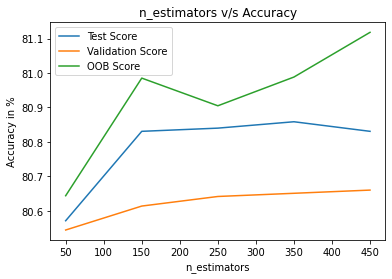

In [20]:
#Changing n_estimators
n_est_lst = grid['n_estimators']
val_score_lst = []
test_score_lst = []
oob_score_lst = []
for n_est in tqdm(n_est_lst):
    clf = RandomForestClassifier(n_estimators=n_est, max_features=optimal_max_features, min_samples_split=optimal_min_samples_split, oob_score=True, n_jobs=mp.cpu_count()//2).fit(X_train, Y_train)
    test_score_lst.append(clf.score(X_test, Y_test)*100)
    val_score_lst.append(clf.score(X_val, Y_val)*100)
    oob_score_lst.append(clf.oob_score_*100)

plt.plot(n_est_lst, test_score_lst, label='Test Score')
plt.plot(n_est_lst, val_score_lst, label='Validation Score')
plt.plot(n_est_lst, oob_score_lst, label='OOB Score')
plt.legend()
plt.title('n_estimators v/s Accuracy')
plt.xlabel('n_estimators')
plt.ylabel('Accuracy in %')
plt.show()

100%|██████████| 5/5 [07:26<00:00, 89.30s/it]


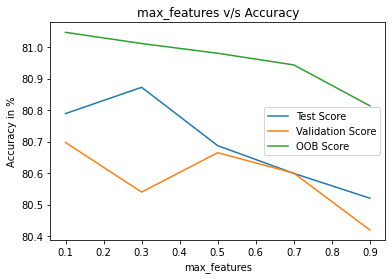

In [17]:
#Changing max_features
max_feat_lst = grid['max_features']
val_score_lst = []
test_score_lst = []
oob_score_lst = []
for max_feat in tqdm(max_feat_lst):
    clf = RandomForestClassifier(n_estimators=optimal_n_estimators, max_features=max_feat, min_samples_split=optimal_min_samples_split, oob_score=True, n_jobs=mp.cpu_count()//2).fit(X_train, Y_train)
    test_score_lst.append(clf.score(X_test, Y_test)*100)
    val_score_lst.append(clf.score(X_val, Y_val)*100)
    oob_score_lst.append(clf.oob_score_*100)

plt.plot(max_feat_lst, test_score_lst, label='Test Score')
plt.plot(max_feat_lst, val_score_lst, label='Validation Score')
plt.plot(max_feat_lst, oob_score_lst, label='OOB Score')
plt.legend()
plt.title('max_features v/s Accuracy')
plt.xlabel('max_features')
plt.ylabel('Accuracy in %')
plt.show()

100%|██████████| 5/5 [02:41<00:00, 32.39s/it]


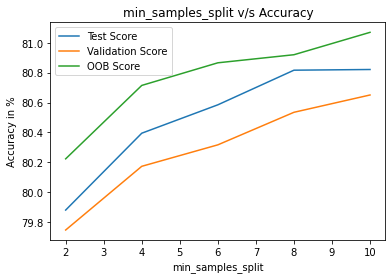

In [12]:
#Changing min_samples_split
min_sam_lst = grid['min_samples_split']
val_score_lst = []
test_score_lst = []
oob_score_lst = []
for min_sam in tqdm(min_sam_lst):
    clf = RandomForestClassifier(n_estimators=optimal_n_estimators, max_features=optimal_max_features, min_samples_split=min_sam, oob_score=True, n_jobs=mp.cpu_count()//2).fit(X_train, Y_train)
    test_score_lst.append(clf.score(X_test, Y_test)*100)
    val_score_lst.append(clf.score(X_val, Y_val)*100)
    oob_score_lst.append(clf.oob_score_*100)

plt.plot(min_sam_lst, test_score_lst, label='Test Score')
plt.plot(min_sam_lst, val_score_lst, label='Validation Score')
plt.plot(min_sam_lst, oob_score_lst, label='OOB Score')
plt.legend()
plt.title('min_samples_split v/s Accuracy')
plt.xlabel('min_samples_split')
plt.ylabel('Accuracy in %')
plt.show()

In [ ]:
    
#     def fit1(self, X, Y, X_test=None, Y_test=None, X_val=None, Y_val=None):
#         '''
#             Builds Tree using viven Train Dataset
#         '''
#         if self.get_train_data and (X_test is None or Y_test is None or X_val is None or Y_val is None):
#             raise Exception('Please pass test and validation data to get train_data or pass get_train_data=False')
#         queue = []
#         X_train = X.copy()
#         Y_train = Y.copy()
        
#         n_samples, n_feat = X.shape
#         nY1 = (Y==1).sum()
#         nY0 = n_samples - nY1
#         majClass = 1 if nY1>nY0 else 0
        
#         bestSplit, median, maxIG = self._getBestSplit(X, Y)
#         self.cnt+=1
#         self.root = DTNode(splitFeat=bestSplit, splitVal=median, majorityClass=majClass)
#         self.root.left = DTNode(parent=self.root, isLeft=True, majorityClass=majClass)
#         self.root.right = DTNode(parent=self.root, isLeft=False, majorityClass=majClass)
#         queue.append(self.root.left)
#         queue.append(self.root.right)
#         self.root.X=X
#         self.root.Y=Y
        
#         while queue!=[]:
#             if self.get_train_data and (self.cnt)%self.record_data_frequency==0:
#                 self._record_accuracies(X_train, Y_train, X_test, Y_test, X_val, Y_val)
    
#             self.cnt+=1
#             node = queue.pop(0)
#             X = node.parent.X
#             Y = node.parent.Y
#             if node.isLeft:
#                 X_ = X[X[:,node.parent.splitFeat]<=node.parent.splitVal]
#                 Y_ = Y[X[:,node.parent.splitFeat]<=node.parent.splitVal]
#             else:
#                 X_ = X[X[:,node.parent.splitFeat]>node.parent.splitVal]
#                 Y_ = Y[X[:,node.parent.splitFeat]>node.parent.splitVal]
#             n_samples_, n_feat_ = X_.shape
#             nY1_ = (Y_==1).sum()
#             nY0_ = n_samples_ - nY1_
#             majClass = 1 if nY1_>nY0_ else 0
#             node.majorityClass=majClass
#             if (nY1_ == 0) or (nY0_==0):
#                 self.leafNodes+=1
#                 continue
#             else:
#                 bestSplit_, median_, maxIG_ = self._getBestSplit(X_, Y_)
#                 if(bestSplit_==-np.inf) or maxIG_==0:
#                     self.leafNodes+=1
#                     continue
#                 node.splitFeat = bestSplit_
#                 node.splitVal = median_
#                 node.X = X_
#                 node.Y = Y_
#                 node.left = DTNode(parent=node, isLeft=True, majorityClass=majClass)
#                 node.right = DTNode(parent=node, isLeft=False, majorityClass=majClass)
#                 queue.append(node.left)
#                 queue.append(node.right)
        
#         if self.get_train_data:
#             self._record_accuracies(X_train, Y_train, X_test, Y_test, X_val, Y_val)
# #         print('Generate tree with %d Nodes'%(self.cnt))    

In [8]:
leaves = 0
leaves1 = 0
leaves0=0
nodes = 0
def isLeaf(node):
    if (node.left==None and node.right!=None) or (node.left!=None and node.right==None):
        print('Problem')
    if node.left==None and node.right==None:
        return True
    else:
        return False
    
def dfs(node):
    global leaves
    global nodes
    global leaves1
    global leaves0
    
    nodes+=1
    if isLeaf(node):
        leaves += 1
        if(node.majorityClass==1):
            leaves1+=1
        else:
            leaves0+=1
        return 1
    
    mx_depth=0
    
    mx_depth = max(mx_depth, dfs(node.left))
    mx_depth = max(mx_depth, dfs(node.right))
    return mx_depth+1

print('max_depth', dfs(dt.root))
print('Number of nodes', nodes)
print('Number of leaves', leaves)
print('Number of leaves with y=1', leaves1)
print('Number of leaves with y=0', leaves0)




################################DT node with option of training with iterative or recursive approach####################
# class DTNode:
    
#     def __init__(self, splitFeat=None, splitVal=None, majorityClass=None, parent=None, isLeft=True):
#         self.splitFeat = splitFeat
#         self.splitVal = splitVal
#         self.majorityClass = majorityClass
#         self.parent = parent
#         self.isLeft = isLeft
#         self.left = None
#         self.right = None
#         self.X = None
#         self.Y = None

# class DecisionTree:
    
#     def __init__(self, get_train_data=False, generate_iteratively=True, min_IG_split = 1e-30, record_data_frequency=100):
#         self.root = None
#         self.cnt = 1
#         self.get_train_data = get_train_data
#         self.min_IG_split = min_IG_split
#         self.generate_iteratively = generate_iteratively
#         self.record_data_frequency = record_data_frequency
#         if self.get_train_data:
#             self.train_data = {'train_acc':[], 'test_acc':[], 'val_acc':[]}
        
#     def fit(self, X, Y, X_test=None, Y_test=None, X_val=None, Y_val=None):
#         if self.get_train_data and (X_test is None or Y_test is None or X_val is None or Y_val is None):
#             raise Exception('Please pass test and validation data to get train_data or pass get_train_data=False')
#         if self.generate_iteratively:
#             self.fit_iterative(X, Y, X_test, Y_test, X_val, Y_val)
#         else:
#             self.fit_recursive(X, Y, X_test, Y_test, X_val, Y_val)
#     def fit_recursive(self, X, Y, X_test=None, Y_test=None, X_val=None, Y_val=None):
        
#         X_train = X.copy()
#         Y_train = Y.copy()
        
#         (n_samples, n_feat) = X.shape
#         nY1 = (Y==1).sum()
#         nY0 = n_samples - nY1
#         majClass = 1 if nY1>nY0 else 0

#         bestSplit, median, max_IG = self._getBestSplit(X, Y)

#         self.root = DTNode(splitFeat=bestSplit, splitVal=median, majorityClass=majClass)
#         self.root.left = self._growTree(X[X[:,bestSplit]<=median], Y[X[:,bestSplit]<=median], X_train, Y_train, X_test, Y_test, X_val, Y_val)
#         self.root.right = self._growTree(X[X[:,bestSplit]>median], Y[X[:,bestSplit]>median], X_train, Y_train, X_test, Y_test, X_val, Y_val)
#         if self.get_train_data:
#             self.train_data['train_acc'].append(self.score(X_train, Y_train))
#             self.train_data['test_acc'].append(self.score(X_test, Y_test))
#             self.train_data['val_acc'].append(self.score(X_val, Y_val))
#         print('Generate tree with %d Nodes'%(self.cnt))
        
    
#     def _growTree(self, X, Y, X_train, Y_train, X_test, Y_test, X_val, Y_val):
        
#         if self.get_train_data and (self.cnt-1)%self.record_data_frequency==0:
#                 self.train_data['train_acc'].append(self.score(X_train, Y_train))
#                 self.train_data['test_acc'].append(self.score(X_test, Y_test))
#                 self.train_data['val_acc'].append(self.score(X_val, Y_val))
                
#         self.cnt+=1
#         (n_samples, n_feat) = X.shape
#         nY1 = (Y==1).sum()
#         nY0 = n_samples - nY1
        
#         majClass = 1 if nY1>nY0 else 0
        
#         if (nY1==0) or (nY0==0):
#             return DTNode(majorityClass=majClass)
#         else:
#             bestSplit, median, max_IG = self._getBestSplit(X, Y)
#             if bestSplit==-np.inf or max_IG<self.min_IG_split:
#                 return DTNode(majorityClass=majClass)
            
#             node_ = DTNode(splitFeat=bestSplit, splitVal=median, majorityClass=majClass)
#             node_.left = self._growTree(X[X[:,bestSplit]<=median], Y[X[:,bestSplit]<=median], X_train, Y_train, X_test, Y_test, X_val, Y_val)
#             node_.right = self._growTree(X[X[:,bestSplit]>median], Y[X[:,bestSplit]>median], X_train, Y_train, X_test, Y_test, X_val, Y_val)
#             return node_
        
        
#     def fit_iterative(self, X, Y, X_test=None, Y_test=None, X_val=None, Y_val=None):
#         queue = []
#         X_train = X.copy()
#         Y_train = Y.copy()
        
#         n_samples, n_feat = X.shape
#         nY1 = (Y==1).sum()
#         nY0 = n_samples - nY1
#         majClass = 1 if nY1>nY0 else 0
        
#         bestSplit, median, maxIG = self._getBestSplit(X, Y)
        
#         self.root = DTNode(splitFeat=bestSplit, splitVal=median, majorityClass=majClass)
#         self.root.left = DTNode(parent=self.root, isLeft=True, majorityClass=majClass)
#         self.root.right = DTNode(parent=self.root, isLeft=False, majorityClass=majClass)
#         queue.append(self.root.left)
#         queue.append(self.root.right)
#         self.root.X=X
#         self.root.Y=Y
        
#         while queue!=[]:
# #             print(len(queue))
# #             print(self.cnt)
#             if self.get_train_data and (self.cnt-1)%self.record_data_frequency==0:
#                 self.train_data['train_acc'].append(self.score(X_train, Y_train))
#                 self.train_data['test_acc'].append(self.score(X_test, Y_test))
#                 self.train_data['val_acc'].append(self.score(X_val, Y_val))
    
#             self.cnt+=1
#             node = queue.pop(0)
#             X = node.parent.X
#             Y = node.parent.Y
#             if node.isLeft:
#                 X_ = X[X[:,node.parent.splitFeat]<=node.parent.splitVal]
#                 Y_ = Y[X[:,node.parent.splitFeat]<=node.parent.splitVal]
#             else:
#                 X_ = X[X[:,node.parent.splitFeat]>node.parent.splitVal]
#                 Y_ = Y[X[:,node.parent.splitFeat]>node.parent.splitVal]
#             n_samples_, n_feat_ = X_.shape
#             nY1_ = (Y_==1).sum()
#             nY0_ = n_samples_ - nY1_
#             majClass = 1 if nY1_>nY0_ else 0
#             node.majorityClass=majClass
#             if (nY1_ == 0) or (nY0_==0):
#                 continue
#             else:
#                 bestSplit_, median_, maxIG_ = self._getBestSplit(X_, Y_)
#                 if(bestSplit_==-np.inf) or maxIG_<self.min_IG_split:
#                     continue
#                 node.splitFeat = bestSplit_
#                 node.splitVal = median_
#                 node.X = X_
#                 node.Y = Y_
#                 node.left = DTNode(parent=node, isLeft=True, majorityClass=majClass)
#                 node.right = DTNode(parent=node, isLeft=False, majorityClass=majClass)
#                 queue.append(node.left)
#                 queue.append(node.right)
#         if self.get_train_data:
#             self.train_data['train_acc'].append(self.score(X_train, Y_train))
#             self.train_data['test_acc'].append(self.score(X_test, Y_test))
#             self.train_data['val_acc'].append(self.score(X_val, Y_val))
#         print('Generate tree with %d Nodes'%(self.cnt))
        
        
#     def _getBestSplit(self, X, Y):        
#         n_samples, n_feat = X.shape
#         optimal_split, optimal_median = -np.inf, -np.inf
#         max_IG = -np.inf
#         median_arr = np.median(X, axis=0)
#         for i in range(n_feat):
#             median = median_arr[i]
# #             median = np.median(X[:,i])
#             ig = self._getInformationGain(X,Y,i,median)
#             if ig > max_IG:
#                 max_IG = ig
#                 optimal_split = i
#                 optimal_median = median
#         return (optimal_split, optimal_median, max_IG)
        
#     def _entropy(self, X, Y):
#         n_samples, n_feat = X.shape
#         nY1 = (Y==1).sum()
#         nY0 = n_samples-nY1
        
#         if n_samples==0:
#             return np.inf
#         elif nY1==0 or nY0==0:
#             return 0
#         else:
#             return (-nY0*math.log(nY0/n_samples)-nY1*math.log(nY1/n_samples))/n_samples
    
#     def _getInformationGain(self, X, Y, i, median):
        
#         entBefore = self._entropy(X,Y)
        
#         X_lte = X[X[:,i]<=median]
#         Y_lte = Y[X[:,i]<=median]
#         X_gt = X[X[:,i]>median]
#         Y_gt = Y[X[:,i]>median]
        
#         entAfter = ((Y_lte.shape[0])*self._entropy(X_lte, Y_lte) + (Y_gt.shape[0])*self._entropy(X_gt, Y_gt))/(Y.shape[0])
#         return (entBefore-entAfter)
    
#     def score(self, X, Y):
#         return (self.predict(X)==Y).sum()/Y.shape[0]
    
#     def predict(self, X):
#         pred=[]
#         for row in X:
#             pred.append(self._predict(row))
#         return pred
    
#     def _predict(self, row):
#         node=self.root
#         while(node.left is not None and node.right is not None):
#             if row[node.splitFeat]<=node.splitVal:
#                 node=node.left
#             elif row[node.splitFeat]>node.splitVal:
#                 node=node.right
#         pred = node.majorityClass
#         return pred
    
#     def plot_training_data(self):
#         if self.get_train_data:
#             plt.figure(figsize=(12,8))
#             n_nodes_lst = list(range(1,(len(self.train_data['train_acc'])-1)*self.record_data_frequency, self.record_data_frequency))
#             n_nodes_lst.append(self.cnt)
#             plt.plot(n_nodes_lst, self.train_data['train_acc'], label='Train Accuracy')
#             plt.plot(n_nodes_lst, self.train_data['test_acc'], label='Test Accuracy')
#             plt.plot(n_nodes_lst, self.train_data['val_acc'], label='Validation Accuracy')
#             plt.legend()
#             plt.xlabel('Number of nodes')
#             plt.ylabel('Accuracies')
#             plt.title('Number of nodes v/s Accuracies')
#             plt.show()
#         else:
#             raise Exception('Please pass get_train_data=True to get this plot')

max_depth 53
Number of nodes 21007
Number of leaves 10504
Number of leaves with y=1 4819
Number of leaves with y=0 5685
